# An example notebook to evaluate NetColoc scores for a range of thresholds on scored input gene lists

# _Obtain input gene sets and interactome_

In [1]:
# load required packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import re
import random

from IPython.display import display

import getpass
import ndex2

import json
import cdapsutil

from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

from scipy.stats import hypergeom
from scipy.stats import norm

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set(font_scale=1.4)

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

from datetime import datetime
import sys
%matplotlib inline

DISCLAIMIER: cdapsutil is experimental and may contain errors and interfaces may change


In [2]:
# verify DDOT was installed
import ddot

# import NetColoc
from netcoloc import netprop_zscore, netprop, network_colocalization, validation

# import NetColoc
# import sys
# sys.path.append('../netcoloc/')
# import netprop_zscore
# import netprop
# import network_colocalization
# import validation

# Load molecular interaction network

In [3]:
interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf' # for PCNet
# interactome_uuid='275bd84e-3d18-11e8-a935-0ac135e8bacf' # for STRING high confidence
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_int = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_int.nodes)

# remove self edges from network
G_int.remove_edges_from(nx.selfloop_edges(G_int))

# print out the numbers of nodes and edges in the interatome for diagnostic purposes:
print('Number of nodes:',len(G_int.nodes))
print('\nNumber of edges:', len(G_int.edges))

Number of nodes: 18820

Number of edges: 2693109


In [4]:
int_nodes = list(G_int.nodes)

In [5]:
# pre-calculate matrices used for network propagation. this step takes a few minutes, more for denser interactomes
print('\ncalculating w_prime')
w_prime = netprop.get_normalized_adjacency_matrix(G_int, conserve_heat=True)

print('\ncalculating w_double_prime')
w_double_prime = netprop.get_individual_heats_matrix(w_prime, .5)


calculating w_prime

calculating w_double_prime


# Select two gene sets of interest. Load gene sets from text files into python

Here we select two public differential expression results (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6124454/). 

These data identify genes which distinguish steatosis-independent and steatosis-driven advanced fibrosis. Here we select steatosis-independent advanced vs early fibrosis and steatosis-driven advanced vs early fibrosis as our input gene lists.

Data downloaded from https://www.ebi.ac.uk/gxa/experiments/E-MTAB-6863/Downloads

In [6]:
DE_df = pd.read_csv('data/E-MTAB-6863-query-results.tsv',
                   sep='\t',skiprows=3)
print("Number of genes with DE results:", len(DE_df))
DE_df.head()

Number of genes with DE results: 25305


,Gene ID,Gene Name,'advanced' vs 'early' in 'no steatosis; liver disease; Hepatitis C virus genotype 1' .foldChange,'advanced' vs 'early' in 'no steatosis; liver disease; Hepatitis C virus genotype 1'.pValue,'advanced' vs 'early' in 'no steatosis; liver disease; Hepatitis C virus genotype 3' .foldChange,'advanced' vs 'early' in 'no steatosis; liver disease; Hepatitis C virus genotype 3'.pValue,'advanced' vs 'early' in 'steatosis; liver disease; Hepatitis C virus genotype 1' .foldChange,'advanced' vs 'early' in 'steatosis; liver disease; Hepatitis C virus genotype 1'.pValue,'advanced' vs 'early' in 'steatosis; liver disease; Hepatitis C virus genotype 3' .foldChange,'advanced' vs 'early' in 'steatosis; liver disease; Hepatitis C virus genotype 3'.pValue,'advanced' vs 'early' in 'steatosis; non-alcoholic fatty liver disease; not applicable' .foldChange,'advanced' vs 'early' in 'steatosis; non-alcoholic fatty liver disease; not applicable'.pValue
0,ENSG00000000003,TSPAN6,NaN,NaN,-0.4,0.281913,-0.3,0.877886,-0.3,0.829151,0.2,0.769741
1,ENSG00000000005,TNMD,NaN,NaN,NaN,NaN,0.1,0.985520,NaN,NaN,NaN,NaN
2,ENSG00000000419,DPM1,NaN,NaN,-0.3,0.499480,-0.1,0.946040,-0.1,0.938291,0.5,0.304146
3,ENSG00000000457,SCYL3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,0.825765
4,ENSG00000000460,C1orf112,NaN,NaN,0.6,0.309036,NaN,NaN,-0.3,0.833355,0.1,0.927387


In [7]:
# define the first gene set data frame:
D1_df = DE_df[['Gene Name',"'advanced' vs 'early' in 'steatosis; liver disease; Hepatitis C virus genotype 3'.pValue",
              "'advanced' vs 'early' in 'steatosis; liver disease; Hepatitis C virus genotype 3' .foldChange"]]
D1_df.columns=['Gene Name','pvalue','foldchange']
D1_df = D1_df.assign(abs_foldchange=D1_df['foldchange'].abs())
D1_df = D1_df[D1_df['pvalue']<0.1] # select genes which are marginally significant
print("Number of DE genes, steatosis:", len(D1_df))
D1_df.head()

# define the second gene set data frame:
D2_df = DE_df[['Gene Name',"'advanced' vs 'early' in 'no steatosis; liver disease; Hepatitis C virus genotype 3'.pValue",
              "'advanced' vs 'early' in 'no steatosis; liver disease; Hepatitis C virus genotype 3' .foldChange"]]
D2_df.columns=['Gene Name','pvalue','foldchange']
D2_df = D2_df.assign(abs_foldchange=D2_df['foldchange'].abs())
D2_df = D2_df[D2_df['pvalue']<0.1] # select genes which are marginally significant
print("Number of DE genes, no steatosis:", len(D2_df))
D2_df.head()

Number of DE genes, steatosis: 468
Number of DE genes, no steatosis: 1011


,Gene Name,pvalue,foldchange,abs_foldchange
12,LAS1L,0.096526,-0.8,0.8
15,CFTR,0.077749,1.4,1.4
45,ARF5,0.092380,-1.1,1.1
49,AK2,0.092759,-0.8,0.8
51,FKBP4,0.056916,-1.0,1.0


# Compute the NetColoc scores for a range of log fold change cutoffs (from 0.5 through 2.0)

In [8]:
netcoloc_pval_df=network_colocalization.sweep_input_pvals(D1_df,D2_df,
                                                          w_double_prime,
                      int_nodes,dict(G_int.degree),
                      cutoff_list = np.arange(.5,2.0,.1),
                      gene_column='Gene Name',
                      score_column='abs_foldchange',
                      cutoff_max=False,
                     num_reps=100,
                     verbose=True,
                     z_score_threshold=3,
                     z12_threshold=1.5)


cutoff = 0.5
number of D1 genes = 459
number of D2 genes = 1004
number of shared genes = 117
size of network intersection = nan
observed size/ expected size = nan
p = nan

cutoff = 0.6
number of D1 genes = 441
number of D2 genes = 984
number of shared genes = 111
size of network intersection = nan
observed size/ expected size = nan
p = nan

cutoff = 0.7
number of D1 genes = 412
number of D2 genes = 926
number of shared genes = 104
size of network intersection = nan
observed size/ expected size = nan
p = nan

cutoff = 0.7999999999999999
number of D1 genes = 412
number of D2 genes = 926
number of shared genes = 104
size of network intersection = nan
observed size/ expected size = nan
p = nan

cutoff = 0.8999999999999999
number of D1 genes = 370
number of D2 genes = 832
number of shared genes = 91
size of network intersection = nan
observed size/ expected size = nan
p = nan

cutoff = 0.9999999999999999
number of D1 genes = 315
number of D2 genes = 717
number of shared genes = 79
size of 



Calculating D2 variant z-scores: 




cutoff = 1.1999999999999997
number of D1 genes = 189
number of D2 genes = 369
number of shared genes = 42
size of network intersection = 631
observed size/ expected size = 2.0134656498292864
p = 2.5394644377780988e-76

Calculating D1 variant z-scores: 




Calculating D2 variant z-scores: 




cutoff = 1.2999999999999998
number of D1 genes = 128
number of D2 genes = 226
number of shared genes = 25
size of network intersection = 723
observed size/ expected size = 2.60615672986807
p = 2.339884708959647e-195

Calculating D1 variant z-scores: 




Calculating D2 variant z-scores: 




cutoff = 1.4
number of D1 genes = 61
number of D2 genes = 102
number of shared genes = 10
size of network intersection = 544
observed size/ expected size = 2.6138766096482797
p = 4.282615600586062e-171

Calculating D1 variant z-scores: 




Calculating D2 variant z-scores: 




cutoff = 1.4999999999999998
number of D1 genes = 61
number of D2 genes = 102
number of shared genes = 10
size of network intersection = 544
observed size/ expected size = 2.6138766096482797
p = 4.282615600586062e-171

Calculating D1 variant z-scores: 




Calculating D2 variant z-scores: 




cutoff = 1.5999999999999996
number of D1 genes = 44
number of D2 genes = 63
number of shared genes = 6
size of network intersection = 540
observed size/ expected size = 2.6230145237285667
p = 2.620160910475618e-140

Calculating D1 variant z-scores: 




Calculating D2 variant z-scores: 




cutoff = 1.6999999999999997
number of D1 genes = 28
number of D2 genes = 46
number of shared genes = 2
size of network intersection = 406
observed size/ expected size = 2.0229197807673147
p = 2.216794402091626e-60

Calculating D1 variant z-scores: 




Calculating D2 variant z-scores: 




cutoff = 1.7999999999999998
number of D1 genes = 16
number of D2 genes = 34
number of shared genes = 2
size of network intersection = 428
observed size/ expected size = 2.3620309050772628
p = 2.2744195855414015e-112

Calculating D1 variant z-scores: 




Calculating D2 variant z-scores: 




cutoff = 1.8999999999999997
number of D1 genes = 14
number of D2 genes = 25
number of shared genes = 2
size of network intersection = 409
observed size/ expected size = 2.4218379914732355
p = 1.9367402713508726e-110


# Plot the results to inform choice of threshold

We recommend choosing the threshold which optimizes the observed divided by expected network intersection size.

In this case, that value is abs(log fold change)>1.3

In [9]:
netcoloc_pval_df.sort_values('obs_exp',ascending=False).head()

,score_cutoff,D1_num_genes,D2_num_genes,num_shared_genes,observed_overlap,expected_overlap_mean,expected_overlap_std,empirical_p,obs_exp
11,1.6,44,63,6,540.0,205.87,13.264731,2.620161e-140,2.623015
9,1.4,61,102,10,544.0,208.12,12.056766,4.282616e-171,2.613877
10,1.5,61,102,10,544.0,208.12,12.056766,4.282616e-171,2.613877
8,1.3,128,226,25,723.0,277.42,14.955387,2.339885e-195,2.606157
14,1.9,14,25,2,409.0,168.88,10.768733,1.936740e-110,2.421838


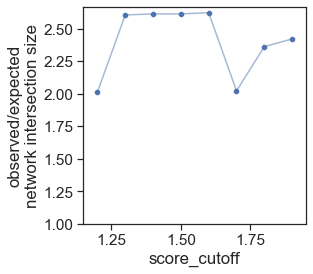

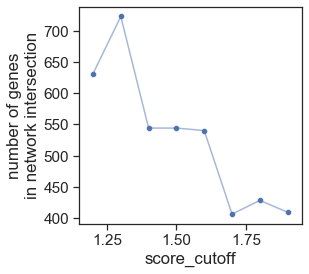

In [10]:
# plot the results
plt.figure(figsize=(4,4))
netcoloc_pval_df['average_D1_D2_num_genes']=(netcoloc_pval_df['D1_num_genes']+netcoloc_pval_df['D2_num_genes'])/2.0
sns.scatterplot(x='score_cutoff',y='obs_exp',data=netcoloc_pval_df.dropna(),legend=False)
sns.lineplot(x='score_cutoff',y='obs_exp',data=netcoloc_pval_df.dropna(),legend=False,alpha=.5)
ymax=plt.gca().get_ylim()[1]
plt.ylim([1,ymax])
_ = plt.ylabel('observed/expected\nnetwork intersection size')

plt.figure(figsize=(4,4))
sns.scatterplot(x='score_cutoff',y='observed_overlap',data=netcoloc_pval_df.dropna(),legend=False)
sns.lineplot(x='score_cutoff',y='observed_overlap',data=netcoloc_pval_df.dropna(),legend=False,alpha=.5)

_ = plt.ylabel('number of genes\nin network intersection')